In [62]:
import pandas as pd
# Set option to display all rows
pd.set_option('display.max_rows', None)

# Set option to display all columns
pd.set_option('display.max_columns', None)

In [ ]:
def clean_data(df):
    df = df[(df['Extruder Pressure'] >= 0) & (df['Extruder Pressure'] < 50000)]
    
    return df

In [37]:
def clean_extruder_data(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data

def get_machine_pauses(df, time_threshold=30, index=True):
    if index:
        time_diff = -1*(df.index.diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold].index
    else:
        time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold]['Date and Time']
    
    return machine_pauses

In [38]:
def hours_since_last_pause(time, pauses):
    return (time - pauses[pauses <= time].max()).total_seconds()/3600

def hours_to_next_pause(time, pauses):
    return (pauses[pauses >= time].min() - time).total_seconds()/3600

In [39]:
ex4_data = clean_extruder_data( pd.read_csv("ex4-data.csv") )
ex4_data = ex4_data.groupby('Date and Time').mean()

/tmp/ipykernel_68537/400673112.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  ex4_data = clean_extruder_data( pd.read_csv("ex4-data.csv") )


In [40]:
#tmp = ex4_data.groupby('Date and Time').mean()

ex4_data['Date and Time'] = ex4_data.index
ex4_pauses = get_machine_pauses(ex4_data, time_threshold=15, index=False)

pauses = ex4_pauses

In [41]:
%%time

ex4_data['hours_since_last_pause'] = ex4_data.index.to_series().apply(
    lambda x : hours_since_last_pause(x, pauses)
)
ex4_data['hours_to_next_pause'] = ex4_data.index.to_series().apply(
    lambda x : hours_to_next_pause(x, pauses)
)

In [42]:
#ex4_data = ex4_data.groupby('Date and Time').mean()

In [43]:
#ex4_resampled = ex4_data.resample('5T').mean()

In [44]:
for time_window in ['5T', '15T', '30T', '1H', '2H', '3H', '6H', '12H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex4_data[col_label] = ex4_data['Extruder Pressure'].rolling(time_window).mean()
    col_label = 'pressure-' + label_append + '_std'
    ex4_data[col_label] = ex4_data['Extruder Pressure'].rolling(time_window).std()

In [45]:
ex4_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,...,pressure-1hour_avg,pressure-1hour_std,pressure-2hour_avg,pressure-2hour_std,pressure-3hour_avg,pressure-3hour_std,pressure-6hour_avg,pressure-6hour_std,pressure-12hour_avg,pressure-12hour_std
Date and Time,,,,,,,,,,,,,,,,,,,,,
2022-11-08 08:45:00,4174.38,63.1,-0.94,11.28,34.120,5.21,0.95,75.36,2022-11-08 08:45:00,NaN,...,4174.3800,NaN,4174.3800,NaN,4174.3800,NaN,4174.3800,NaN,4174.3800,NaN
2022-11-08 08:46:00,4521.09,63.1,-0.94,11.28,34.370,5.21,0.95,75.36,2022-11-08 08:46:00,NaN,...,4347.7350,245.160992,4347.7350,245.160992,4347.7350,245.160992,4347.7350,245.160992,4347.7350,245.160992
2022-11-08 08:49:00,4521.09,63.1,-0.94,11.28,34.620,5.21,1.01,75.36,2022-11-08 08:49:00,NaN,...,4405.5200,200.173112,4405.5200,200.173112,4405.5200,200.173112,4405.5200,200.173112,4405.5200,200.173112
2022-11-08 08:50:00,4521.09,63.1,-0.94,11.28,34.035,5.21,0.90,75.36,2022-11-08 08:50:00,NaN,...,4434.4125,173.355000,4434.4125,173.355000,4434.4125,173.355000,4434.4125,173.355000,4434.4125,173.355000
2022-11-08 08:53:00,4337.32,63.1,-0.94,11.28,33.450,1.74,0.90,75.36,2022-11-08 08:53:00,NaN,...,4414.9940,156.282941,4414.9940,156.282941,4414.9940,156.282941,4414.9940,156.282941,4414.9940,156.282941


In [47]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['5T', '15T', '1H', '3H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_ave'
        ex4_data[col_label] = \
            ex4_data[lagvar].rolling(time_window).mean()
        col_label = colname_map[lagvar] + label_append + '_std'
        ex4_data[col_label] = \
            ex4_data[lagvar].rolling(time_window).std()

In [49]:
ex4_data.shape

(98664, 72)

In [54]:
ex4_data = ex4_data.dropna(subset='hours_since_last_pause')
ex4_data.shape

(39949, 72)

In [78]:
ex4_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,hours_to_next_pause,pressure-5min_avg,pressure-5min_std,pressure-15min_avg,pressure-15min_std,pressure-30min_avg,pressure-30min_std,pressure-1hour_avg,pressure-1hour_std,pressure-2hour_avg,pressure-2hour_std,pressure-3hour_avg,pressure-3hour_std,pressure-6hour_avg,pressure-6hour_std,pressure-12hour_avg,pressure-12hour_std,die_temp-1min_avg,thrust-1min_avg,screw_speed_output-1min_avg,die_temp-5min_avg,thrust-5min_avg,screw_speed_output-5min_avg,die_temp-15min_avg,thrust-15min_avg,screw_speed_output-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,screw_speed_output-1hour_avg,die_temp-3hour_avg,thrust-3hour_avg,screw_speed_output-3hour_avg,die_temp-1min_ave,die_temp-1min_std,thrust-1min_ave,thrust-1min_std,screw_speed_output-1min_ave,screw_speed_output-1min_std,die_temp-5min_ave,die_temp-5min_std,thrust-5min_ave,thrust-5min_std,screw_speed_output-5min_ave,screw_speed_output-5min_std,die_temp-15min_ave,die_temp-15min_std,thrust-15min_ave,thrust-15min_std,screw_speed_output-15min_ave,screw_speed_output-15min_std,die_temp-1hour_ave,die_temp-1hour_std,thrust-1hour_ave,thrust-1hour_std,screw_speed_output-1hour_ave,screw_speed_output-1hour_std,die_temp-3hour_ave,die_temp-3hour_std,thrust-3hour_ave,thrust-3hour_std,screw_speed_output-3hour_ave,screw_speed_output-3hour_std
Date and Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-15 18:56:00,910.626,25.0,-0.94,11.62,4.700,0.000,0.888,80.0,2023-01-15 18:56:00,0.000000,0.000000,585.188,460.238833,2215.198563,1470.905693,2906.988732,1432.214468,3679.016612,1177.061907,4029.199210,861.785030,4099.762778,709.428761,4216.707210,543.103289,4223.855498,409.668339,11.62,4.700,25.0,11.62,13.8125,25.0,11.62,25.739375,25.0,11.62,41.461702,25.0,11.620000,45.285407,25.0,11.62,NaN,4.700,NaN,25.0,NaN,11.62,0.0,13.8125,12.887021,25.0,0.0,11.62,0.0,25.739375,8.848402,25.0,0.0,11.62,0.0,41.461702,10.261014,25.0,0.0,11.620000,0.000000,45.285407,6.030319,25.0,0.0
2023-01-15 20:27:00,6078.000,25.0,-0.94,397.97,-0.235,0.000,0.000,80.0,2023-01-15 20:27:00,1.516667,0.616667,6078.000,NaN,6078.000000,NaN,6078.000000,NaN,6078.000000,NaN,3091.758018,1661.836719,3972.410678,1013.490344,4187.806126,620.976214,4218.943233,440.437212,397.97,-0.235,25.0,397.97,-0.2350,25.0,397.97,-0.235000,25.0,397.97,-0.235000,25.0,18.909623,42.827455,25.0,397.97,NaN,-0.235,NaN,25.0,NaN,397.97,NaN,-0.2350,NaN,25.0,NaN,397.97,NaN,-0.235000,NaN,25.0,NaN,397.97,NaN,-0.235000,NaN,25.0,NaN,18.909623,53.069254,42.827455,10.341737,25.0,0.0
2023-01-15 20:31:00,523.870,25.0,-0.94,397.97,-0.810,0.000,0.000,80.0,2023-01-15 20:31:00,1.583333,0.550000,3300.935,3927.362987,3300.935000,3927.362987,3300.935000,3927.362987,3300.935000,3927.362987,2812.891589,1745.805789,3889.430819,1125.212117,4163.964274,684.234198,4208.298233,479.971804,397.97,-0.810,25.0,397.97,-0.5225,25.0,397.97,-0.522500,25.0,397.97,-0.522500,25.0,26.479615,41.843047,25.0,397.97,NaN,-0.810,NaN,25.0,NaN,397.97,0.0,-0.5225,0.406586,25.0,0.0,397.97,0.0,-0.522500,0.406586,25.0,0.0,397.97,0.0,-0.522500,0.406586,25.0,0.0,26.479615,75.022953,41.843047,12.034863,25.0,0.0
2023-01-15 20:35:00,460.040,25.0,-0.94,397.97,-0.810,5.005,0.000,80.0,2023-01-15 20:35:00,1.650000,0.483333,491.955,45.134626,2353.970000,3225.262493,2353.970000,3225.262493,2353.970000,3225.262493,2377.950942,1761.438348,3771.694338,1242.715567,4138.517656,747.387127,4197.533622,517.869093,397.97,-0.810,25.0,397.97,-0.8100,25.0,397.97,-0.618333,25.0,397.97,-0.618333,25.0,35.274082,40.542213,25.0,397.97,NaN,-0.810,NaN,25.0,NaN,397.97,0.0,-0.8100,0.000000,25.0,0.0,397.97,0.0,-0.618333,0.331976,25.0,0.0,397.97,0.0,-0.618333,0.331976,25.0,0.0,35.274082,93.584042,40.542213,13.700665,25.0,0.0
2023-01-15 20:37:00,460.040,25.0,-0.94,397.97,-0.810,0.000,0.000,80.0,2023-01-15 20:37:00,1.6833

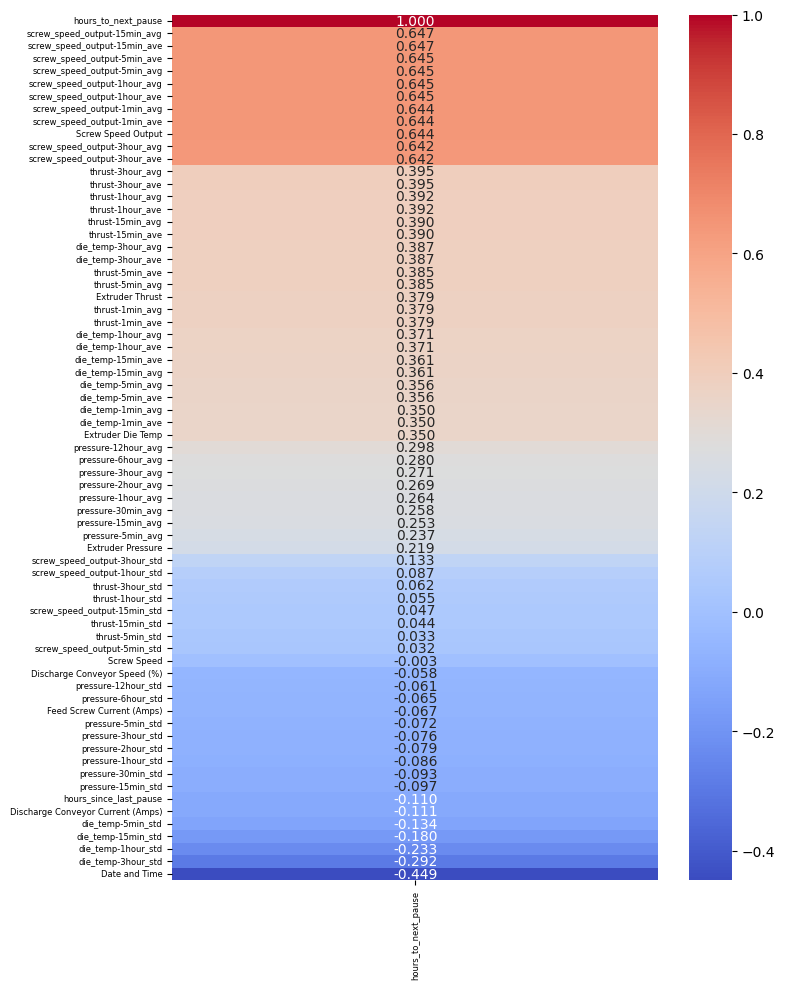

In [77]:
filtered_correlations = correlation_matrix[['hours_to_next_pause']].dropna()
sorted_correlations = filtered_correlations.sort_values(by='hours_to_next_pause', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 10))

# Draw the heatmap
sns.heatmap(
    sorted_correlations, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".3f",
    xticklabels=True,
    yticklabels=True
)

# Rotate labels for better readability
plt.yticks(rotation=0)  # Adjust rotation and font size as needed
plt.xticks(rotation=90)  # Rotate x labels for better fit

# Adjust font size
plt.tick_params(axis='both', which='major', labelsize=6)  # Adjust the font size as needed

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [63]:
filtered_correlations

,hours_to_next_pause
Extruder Pressure,0.218719
Screw Speed Output,0.643741
Screw Speed,-0.002568
Extruder Die Temp,0.350352
Extruder Thrust,0.378676
Feed Screw Current (Amps),-0.066643
Discharge Conveyor Current (Amps),-0.111268
Discharge Conveyor Speed (%),-0.057585
Date and Time,-0.449436
hours_since_last_pause,-0.109926


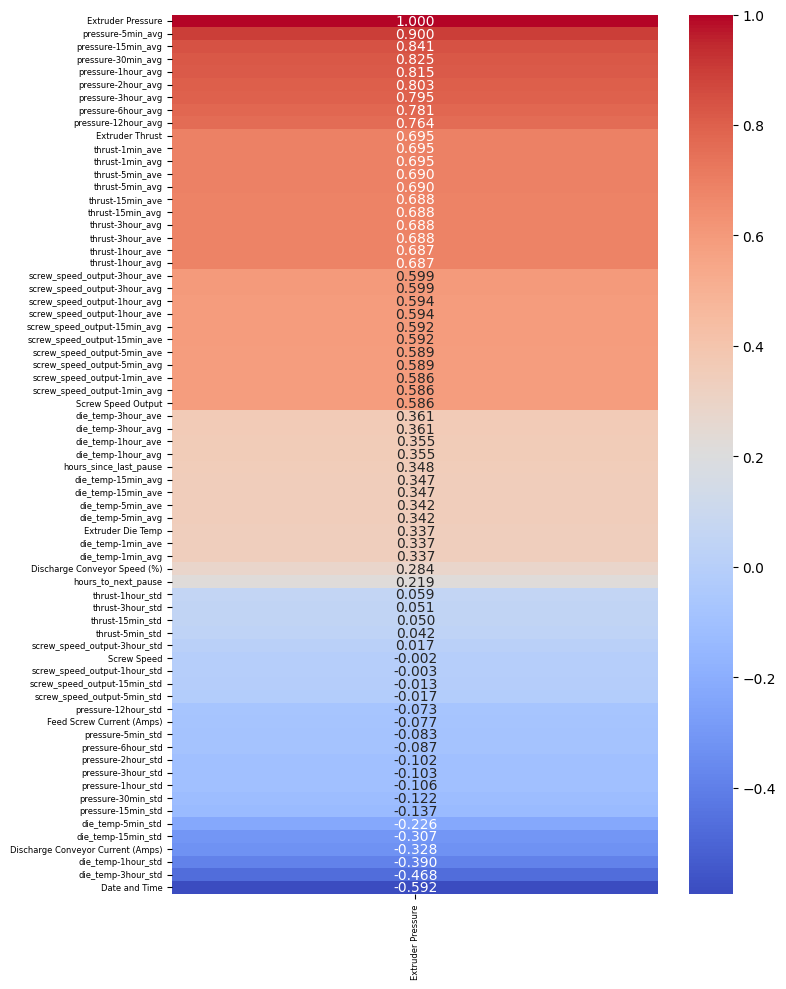

In [76]:
filtered_correlations = correlation_matrix[['Extruder Pressure']].dropna()
sorted_correlations = filtered_correlations.sort_values(by='Extruder Pressure', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 10))

# Draw the heatmap
sns.heatmap(
    sorted_correlations, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".3f",
    xticklabels=True,
    yticklabels=True
)

# Rotate labels for better readability
plt.yticks(rotation=0)  # Adjust rotation and font size as needed
plt.xticks(rotation=90)  # Rotate x labels for better fit

# Adjust font size
plt.tick_params(axis='both', which='major', labelsize=6)  # Adjust the font size as needed

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [75]:
sorted_correlations

,Extruder Pressure
Extruder Pressure,1.000000
pressure-5min_avg,0.899614
pressure-15min_avg,0.840549
pressure-30min_avg,0.825107
pressure-1hour_avg,0.814821
pressure-2hour_avg,0.802501
pressure-3hour_avg,0.795024
pressure-6hour_avg,0.780801
pressure-12hour_avg,0.763601
Extruder Thrust,0.694708
